<a href="https://colab.research.google.com/github/wohaimeishuigou/Awesome-pytorch-list/blob/master/Pytorch_LSTM_Classification_on_Covid_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
! pip install git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 3.4 MB 28.0 MB/s 
     |████████████████████████████████| 311 kB 46.2 MB/s 
     |████████████████████████████████| 895 kB 29.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 45.6 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 243 kB 61.0 MB/s 
     |████████████████████████████████| 133 kB 63.9 MB/s 
     |████████████████████████████████| 94 kB 699 kB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
     |████████████████████████████████| 144 kB 61.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-x7k01g6w
  Running command git clone -q https://github.com/huggingface/transfor

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [53]:
df_train=pd.read_csv("/content/drive/MyDrive/kaggle_Coronavirus tweets NLP - Text Classification/Corona_NLP_train.csv",encoding="latin1")
df_test=pd.read_csv("/content/drive/MyDrive/kaggle_Coronavirus tweets NLP - Text Classification/Corona_NLP_test.csv",encoding="latin1")

#Shuffle DataFrames
df_train=df_train.sample(frac=1)
df_test=df_test.sample(frac=1)

In [54]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
27748,31547,76499,Everywhere,03-04-2020,"#coronavirus &gt; #hospital workers, #security...",Positive
38559,42358,87310,"West Hartford, CT",11-04-2020,@ABC Social Distancing at a grocery store in C...,Neutral
7725,11524,56476,NaN,19-03-2020,@balboanorth Was thinking the same. Maybe take...,Negative
40935,44734,89686,"Tallahassee, FL.",14-04-2020,Despite the current economic slowdown caused b...,Extremely Positive
24997,28796,73748,Shelton CT,29-03-2020,A thank you to our unsung heroes the grocery s...,Extremely Positive


In [55]:
from transformers import RobertaTokenizer
tokenizer=RobertaTokenizer.from_pretrained("roberta-base")

def token_counter(text,tokenizer):
  return len(tokenizer.encode(text))
  #return len(tokenizer.encode(line) for line in text)
  #下面可以用map不
tok_len=df_train["OriginalTweet"].apply(lambda x:token_counter(x,tokenizer))
max(list(tok_len))

#The longest tweet contains 184 tokens,we don't have to use padding uo to the 512th token.
#We will stop at 200 to reduce the size of the tensors handled

184

In [56]:
tokenizer.model_max_length=200

## Data analysis

In [57]:
print("The training dataframe contains {} Tweets".format(len(df_train)))

print("The testing dataframe contains {} Tweets".format(len(df_test)))

The training dataframe contains 41157 Tweets
The testing dataframe contains 3798 Tweets


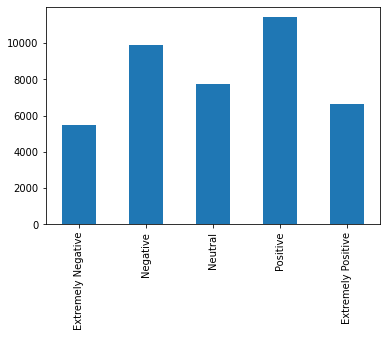

In [58]:
df_train["Sentiment"].value_counts().loc[["Extremely Negative","Negative","Neutral","Positive","Extremely Positive"]].plot(kind="bar")

the dataset is well balanced between categories

## Processing the text

In [59]:
import re
def remove_links(text):
  to_remove=["\r","\n",",",";",":","."]

  out=re.sub(r'http\S+', '', text)

  for token in to_remove:
    out=out.replace(token,'')

  return re.sub(' +',' ', out.lower())#Remove duplicate spaces

In [60]:
def tokenize(text,tokenizer):
  return tokenizer.encode(text,padding='max_length')

name_to_idx={
    "Extremely Negative":0,
    "Negative":1,
    "Neutral":2,
    "Positive":3,
    "Extremely Positive":4
}
def process_tgt(value):
  return name_to_idx[value]

In [61]:
train_text=list(df_train["OriginalTweet"].apply(remove_links).apply(lambda x:tokenize(x,tokenizer)))
train_labels=list(df_train["Sentiment"].apply(process_tgt))

test_text=list(df_test["OriginalTweet"].apply(remove_links).apply(lambda x:tokenize(x,tokenizer)))
test_labels=list(df_test["Sentiment"].apply(process_tgt))

In [62]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        
        
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])
    
    def __len__(self):
        return len(self.labels)

train_dataset = CreateDataset(train_text, train_labels)
test_dataset = CreateDataset(test_text, test_labels)


In [63]:
len(train_dataset),len(test_dataset)

(41157, 3798)

In [64]:
from torch.utils.data import DataLoader

train_loader=DataLoader(train_dataset,batch_size=32)
test_loader=DataLoader(test_dataset,batch_size=32)

## Create the Model

In [65]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers,
                            dropout = dropout,
                            batch_first = True,
                            bidirectional = True)
        self.linear = nn.Linear(512*200, 5)
        
    def forward(self, inputs):
        emb = self.embedding(inputs)
        lstm_out, _ = self.lstm(emb)
        
        output = self.linear(lstm_out.reshape(lstm_out.size()[0], -1))
        
        return output
    
model = LSTMModel(tokenizer.vocab_size, 256, 256, 4, 0.2)


Train the Model

In [66]:
from tqdm import tqdm

class Trainer():
    
    def __init__(self, model, train_loader, valid_loader):
        
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def train_epoch(self, f_loss, optimizer, device):

        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.train()

        correct = 0
        tot_loss = 0
        N = 41157 # Dataset length

        # iterator = tqdm(enumerate(self.train_loader))
        iterator = enumerate(self.train_loader)

        for i, (inputs, targets) in iterator:
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass through the network up to the loss
            outputs = self.model(inputs)

            loss = f_loss(outputs, targets)

            loss_value = loss.item()

            # Backward and optimize

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tot_loss += inputs.shape[0] * loss_value

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            #iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def valid_epoch(self, f_loss, device):
        # We enter train mode. This is useless for the linear model
        # but is important for layers such as dropout, batchnorm, ...
        self.model.eval()

        correct = 0
        tot_loss = 0
        N = 3798 # Dataset length

        # iterator = tqdm(enumerate(self.valid_loader))
        iterator = enumerate(self.valid_loader)

        with torch.no_grad():
            for i, (inputs, targets) in iterator:
                inputs, targets = inputs.to(device), targets.to(device)

                # Compute the forward pass through the network up to the loss
                outputs = self.model(inputs)

                loss = f_loss(outputs, targets)

                tot_loss += inputs.shape[0] * loss.item()

                predicted_targets = outputs.argmax(dim=1)
                correct += (predicted_targets == targets).sum().item()

                # iterator.set_description("loss : {: .3f} | accuracy : {: .3f}".format(tot_loss/(inputs.shape[0]*(i+1)), correct/(inputs.shape[0]*(i+1))))

        return tot_loss/N, correct/N

    def training(self, f_loss, optimizer, device, epochs = 10):

        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []

        for i in range(epochs):
            print("EPOCH {}/{}".format(i + 1, epochs))
            train_results = self.train_epoch(f_loss, optimizer, device)
            print("Training loss : {: .3f} | Training accuracy : {: .3f}".format(*train_results))
            valid_results = self.valid_epoch(f_loss, device)
            print("Validation loss : {: .3f} | Validation accuracy : {: .3f}\n".format(*valid_results))

            train_loss.append(train_results[0])
            train_acc.append(train_results[1])
            valid_loss.append(valid_results[0])
            valid_acc.append(valid_results[1])

        return train_loss, train_acc, valid_loss, valid_acc

In [67]:
device=torch.device('cuda')
model=model.cuda()

In [68]:
f_loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [69]:
trainer=Trainer(model,train_loader,test_loader)

train_loss,train_acc,valid_loss,valid_acc=trainer.training(f_loss,optimizer,device,epochs=8)

EPOCH 1/8
Training loss :  1.211 | Training accuracy :  0.491
Validation loss :  0.985 | Validation accuracy :  0.627

EPOCH 2/8
Training loss :  0.750 | Training accuracy :  0.721
Validation loss :  0.799 | Validation accuracy :  0.718

EPOCH 3/8
Training loss :  0.485 | Training accuracy :  0.829
Validation loss :  0.793 | Validation accuracy :  0.737

EPOCH 4/8
Training loss :  0.325 | Training accuracy :  0.891
Validation loss :  0.903 | Validation accuracy :  0.730

EPOCH 5/8
Training loss :  0.225 | Training accuracy :  0.924
Validation loss :  0.982 | Validation accuracy :  0.746

EPOCH 6/8
Training loss :  0.155 | Training accuracy :  0.948
Validation loss :  1.073 | Validation accuracy :  0.754

EPOCH 7/8
Training loss :  0.114 | Training accuracy :  0.963
Validation loss :  1.242 | Validation accuracy :  0.752

EPOCH 8/8
Training loss :  0.088 | Training accuracy :  0.971
Validation loss :  1.282 | Validation accuracy :  0.755



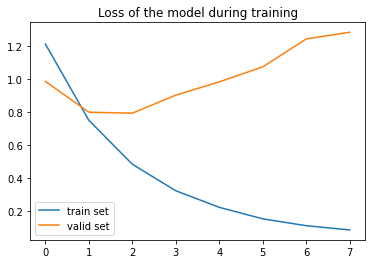

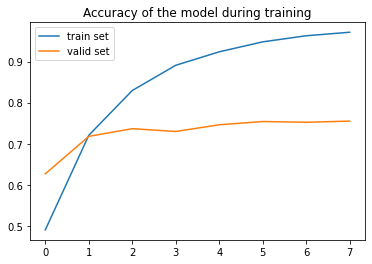

In [70]:
plt.plot(train_loss,label="train set")
plt.plot(valid_loss,label="valid set")
plt.legend()
plt.title("Loss of the model during training")
plt.show()

plt.plot(train_acc,label="train set")
plt.plot(valid_acc,label="valid set")
plt.legend()
plt.title("Accuracy of the model during training")
plt.show()